In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install -q xplique keras_cv
!cp "/content/drive/MyDrive/Harmonizer zoo/data/cka_imagenet_val.npy" ./
!cp -r "/content/drive/MyDrive/Saliency Strike Back/data/resnet50_explanations" ./

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.8/190.8 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.9/601.9 kB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 47.5 MB/s eta 0:00:00


In [2]:
!cp -r "/content/drive/MyDrive/Metrics Baseline/Data/baseline fv" ./

In [5]:
import xplique
from xplique.attributions import *
import tensorflow as tf
import numpy as np
import keras_cv
from keras_cv.models import *

from matplotlib import pyplot as plt
plt.style.use('seaborn')
%config InlineBackend.figure_format = 'retina'

def set_size(w,h):
  """Set matplot figure size"""
  plt.rcParams["figure.figsize"] = [w,h]

def show(img, **kwargs):
  img = np.array(img)
  img -= img.min()
  img /= img.max()
  plt.imshow(img, **kwargs)
  plt.axis('off')

import seaborn as sns
sns.set(font_scale=2)

Using TensorFlow backend


<ipython-input-5-f6199f6b849b>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [6]:
model = tf.keras.applications.ResNet50V2(classifier_activation=None)

def preprocess(images):
  return tf.keras.applications.resnet_v2.preprocess_input(np.array(images, dtype=np.float32))

102869336/102869336 [==============================] - 6s 0us/step


In [7]:
X = np.load('cka_imagenet_val.npy')
X = preprocess(X)

In [8]:
from xplique.attributions import *
from xplique.metrics import *

In [9]:
import cv2

#baseline_fv = cv2.resize(cv2.imread('/content/baseline fv/baseline_resnet.png')[512:-512, 512:-512,::-1], (224, 224)).astype(np.float32)
baseline_fv = cv2.resize(cv2.imread('/content/baseline fv/baseline_resnet.png')[:, :,::-1], (224, 224)).astype(np.float32)
baseline_fv = (baseline_fv / 127.0) - 1.0

def apply_baseline_fv(x):
  return np.array([baseline_fv for _ in range(len(x))])

baselines = {
    'fv': lambda x : apply_baseline_fv(x),
}

In [15]:
feat = tf.keras.Model(model.input, model.layers[-2].output)
a = feat(baseline_fv[None, :, :, :])
np.mean(tf.abs(a))

0.014559988

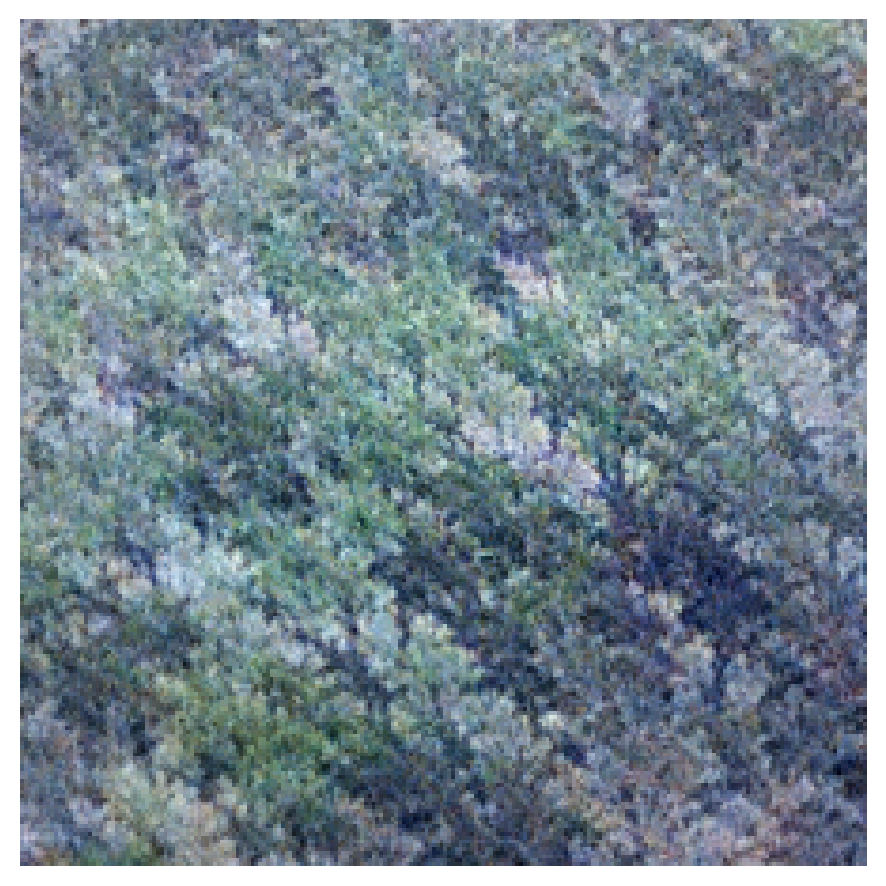

In [16]:
show(baseline_fv)

In [10]:
def generate_path(images, explanations, baseline_func, steps=10):
  images_flatten = np.array(images).reshape((len(images), -1, images.shape[-1]))

  min_img = np.min(images, (1,2,3))
  max_img = np.max(images, (1,2,3))

  if len(explanations.shape) == 4:
    explanations = np.mean(explanations, -1)

  explanations_flatten = explanations.reshape((len(explanations), -1))
  most_important_features = np.argsort(explanations_flatten, axis=-1)[:, ::-1]

  baselines = np.array(baseline_func(images))
  baselines_flatten = baselines.reshape((len(images), -1, images.shape[-1]))

  steps = np.linspace(0, baselines_flatten.shape[1], steps + 1, dtype=np.int32)

  start = images_flatten
  end = baselines_flatten

  ret = []

  for step in steps:
    ids_to_flip = most_important_features[:, :step]
    batch_inputs = start.copy()

    for i, ids in enumerate(ids_to_flip):
      batch_inputs[i, ids] = end[i, ids]

    batch_inputs = batch_inputs.reshape(images.shape)
    batch_inputs = np.clip(batch_inputs, min_img[:, None, None, None], max_img[:, None, None, None])
    ret.append(batch_inputs)

  return ret

In [12]:
H = np.load('/content/resnet50_explanations/resnet50_GradCAM.npy')[:500]
H.shape

(500, 224, 224)

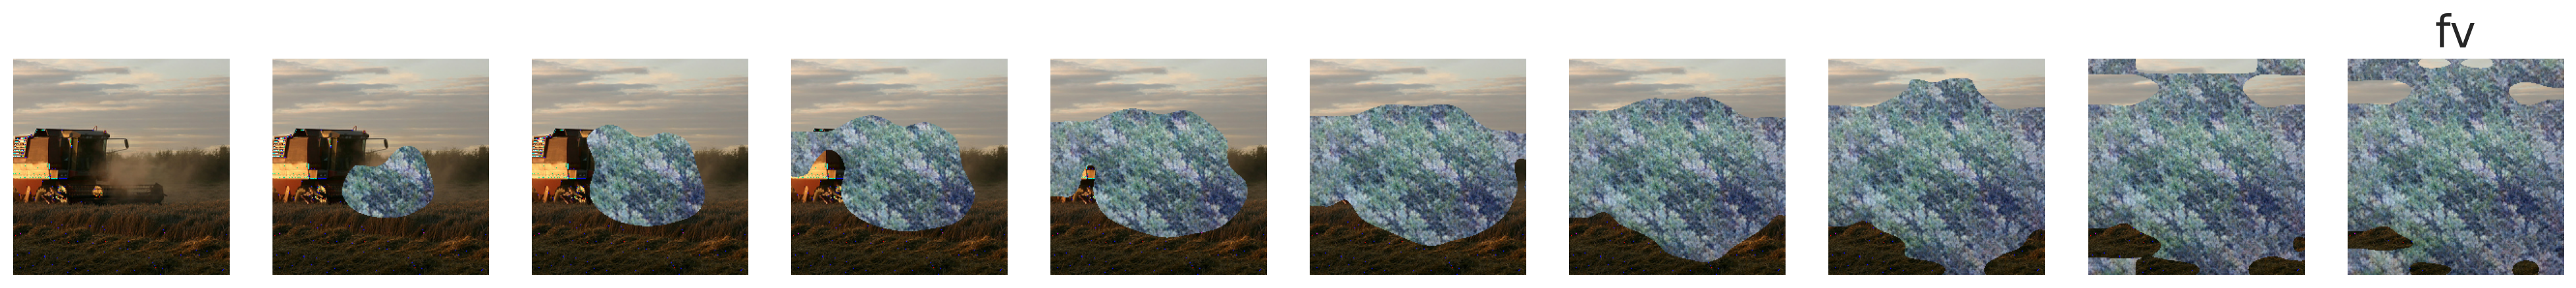

In [29]:
steps = 10

set_size(25, 8)

for baseline_name, baseline_func in baselines.items():
  chunks = generate_path(np.array(X[:10]), np.array(H[:10]), baseline_func, steps=steps)

  for i in range(steps):
    plt.subplot(1, steps, i+1)
    show(chunks[i][0])
  plt.title(baseline_name)
  plt.show()

In [13]:
steps = 20
fn = "removal_scores_resnet_fv.npy"

RESULTS = {}
#RESULTS = np.load(fn, allow_pickle=True)[()]

for baseline_name, baseline_func in baselines.items():
  if baseline_name not in RESULTS:
    RESULTS[baseline_name] = []

    chunks = generate_path(np.array(X[:len(H)]), np.array(H), baseline_func, steps=steps)

    for step_id in range(steps):
      images = chunks[step_id]
      score_removal = np.sum(tf.nn.sigmoid(model.predict(images)))
      RESULTS[baseline_name].append((step_id, score_removal))

    print("done for", baseline_name)
    #np.save(fn, RESULTS)

print(np.mean(RESULTS['fv']))

16/16 [==============================] - 1s 81ms/step
done for fv
119321.14609375


In [14]:
d = [s/1000/1000 for _,s in RESULTS['fv']]
np.mean(d)

0.23863279218750005

In [15]:
steps = 20
fn = "removal_scores_resnet_fv.npy"

RESULTS = {}
#RESULTS = np.load(fn, allow_pickle=True)[()]

for baseline_name, baseline_func in baselines.items():
  if baseline_name not in RESULTS:
    RESULTS[baseline_name] = []

    chunks = generate_path(np.array(X[:len(H)]), np.array(H), baseline_func, steps=steps)

    for step_id in range(steps):
      images = chunks[step_id]
      score_removal = np.sum(tf.nn.sigmoid(model.predict(images)))
      RESULTS[baseline_name].append((step_id, score_removal))

    print("done for", baseline_name)
    np.save(fn, RESULTS)

!cp {fn} "/content/drive/MyDrive/Metrics Baseline/Data/results_resnet"


16/16 [==============================] - 1s 85ms/step
done for fv
